## Author and contributions
- Author: Sam Ochs
- Since my project is only one person I am the author and contributor to all of the below code.

### Acknowledgements - Used Github Copilot (v1.342.0), 2025-07-24
- Copilot used for refactoring help and optimization

#### Libraries and Init

In [53]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect("pga_tour_2024.db")
c = conn.cursor()

#### To Rebuild The Table

In [54]:
# fetch every user-defined table
c.execute("SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';")
tables = [row[0] for row in c.fetchall()]
# drop them one by one
for tbl in tables:
    c.execute(f'DROP TABLE IF EXISTS "{tbl}";')
conn.commit()

#### Helper Function

In [55]:
# helper Functions
def insert_df_to_table(df, table_name, cursor, placeholder="?"):
    #work on a copy
    df2 = df.copy()
    #grab columns & build SQL
    cols = df2.columns.tolist()
    # convert timestamps to strings
    for col in cols:
        if pd.api.types.is_datetime64_any_dtype(df2[col]):
            df2[col] = df2[col].dt.strftime('%Y-%m-%d %H:%M:%S')
        elif pd.api.types.is_timedelta64_dtype(df2[col]):
            df2[col] = df2[col].astype(str)
    # quote every identifier in double-quotes
    col_list = ", ".join(f'"{col}"' for col in cols)
    ph_list = ", ".join(placeholder for _ in cols)
    sql = f'INSERT INTO "{table_name}" ({col_list}) VALUES ({ph_list})'
    # print the SQL for debugging
    print(sql)
    #build the list of tuples
    data = [tuple(row) for row in df2.itertuples(index=False, name=None)]
    #execute the SQL with the data
    cursor.executemany(sql, data)
    conn.commit()

#### Processing Results CSV

In [56]:
# loading the results CSV for 2024
results_2024 = pd.read_csv("./data/2024_results.csv")
# change Date to start_date and end_date
results_2024["start_date"] = pd.to_datetime(
    results_2024["Date"].str.split(" ").str[0]
    + " "
    + results_2024["Date"].str.split(" ").str[1]
    + " 2024",
    format="%b %d %Y",
)
# if len(results_2024["Date"].str.split(' ')[0] greater than 3 the end date is in a different month
for index, row in results_2024.iterrows():
    if len(row["Date"].split(" ")) > 4:
        results_2024.at[index, "end_date"] = pd.to_datetime(
            row["Date"].split(" ")[0] + " " + row["Date"].split(" ")[4] + " 2024",
            format="%b %d %Y",
        )
    else:
        results_2024.at[index, "end_date"] = pd.to_datetime(
            row["Date"].split(" ")[0] + " " + row["Date"].split(" ")[3] + " 2024",
            format="%b %d %Y",
        )
# rename proj. to proj
results_2024.rename(columns={"PROJ.": "proj"}, inplace=True)
# is twosome/non-regular tournament
results_2024["twosome"] = results_2024["PLAYER"].str.contains(" / ", case=False, na=False)
results_2024.drop(results_2024[results_2024["twosome"] == True].index, inplace=True)
# drop the Date column
results_2024.drop(columns=["Date", "twosome"], inplace=True)
# for column in columns lowercase all of them
results_2024.columns = results_2024.columns.str.lower()

#### Create Positions Table

In [57]:
# loading the positions CSV for 2024
positions = pd.read_csv("./data/positions.csv")
# create the positions table
def create_positions_table(positions, c):
    # create the positions table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS positions (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            position      TEXT
        )
    """
    )
    # insert the positions into the table
    insert_df_to_table(positions, "positions", c, placeholder="?")

#### Create Course Table

In [58]:
# loading the courses CSV for 2024
courses = pd.read_csv("./data/courses.csv")
# create the courses table
def create_courses_table(courses, c):
    # create the courses table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS courses (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            name      TEXT
        )
    """
    )
    # insert the courses into the table
    insert_df_to_table(courses, "courses", c, placeholder="?")

#### Create Tournaments Table

In [59]:
# loading the tournaments CSV for 2024
tournaments = pd.read_csv("./data/tournaments.csv")
# create the tournaments table
def create_tournaments_table(tournaments, c):
    # create the tournaments table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS tournaments (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            name      TEXT
        )
    """
    )
    # insert the tournaments into the table
    insert_df_to_table(tournaments, "tournaments", c, placeholder="?")

#### Create Players Table

In [60]:
# loading the players CSV for 2024
players = pd.read_csv("./data/players_2024.csv")
# create the players table
def create_players_table(players, c):
    # create the players table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS players (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            name      TEXT,
            country   TEXT
        )
    """
    )
    # insert the players into the table
    insert_df_to_table(players, "players", c, placeholder="?")

#### Create Results Table

In [61]:
# create the results table
def create_results_table(results_2024, c):
    conn.commit()
    # create the intial results table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS results (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            tournament TEXT NOT NULL,
            course     TEXT NOT NULL,
            player     TEXT NOT NULL,
            pos        INTEGER,
            total      INTEGER,
            thru       TEXT,
            round      INTEGER,
            r1         INTEGER,
            r2         INTEGER,
            r3         INTEGER,
            r4         INTEGER,
            strokes    INTEGER,
            proj       INTEGER,
            starting   INTEGER,
            start_date TEXT,
            end_date   TEXT
        )
    """
    )
    conn.commit()
    # insert the results into the table
    insert_df_to_table(results_2024, "results", c, placeholder="?")
    # alter the results table to add the player_id column
    c.execute("ALTER TABLE results ADD COLUMN player_id INTEGER;")
    conn.commit()
    # update player_id in results table
    c.execute("""
        UPDATE results
        SET player_id = (
            SELECT id
            FROM players
            WHERE players.name = results.player
        ) 
    """)
    conn.commit()
    # alter the results table to add the tournament_id, course_id, and position_id columns
    # and update them with the correct values
    c.execute("ALTER TABLE results ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE results
        SET tournament_id = (
            SELECT tournaments.id
            FROM tournaments
            WHERE tournaments.name = results.tournament
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE results ADD COLUMN course_id INTEGER;")
    c.execute("""
        UPDATE results
        SET course_id = (
            SELECT courses.id
            FROM courses
            WHERE courses.name = results.course
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE results ADD COLUMN position_id INTEGER;")
    c.execute("""
        UPDATE results
        SET position_id = (
            SELECT positions.id
            FROM positions
            WHERE positions.position = results.pos
        ) 
    """)
    conn.commit()
    # rename resutls table to results_old
    c.execute("ALTER TABLE results RENAME TO results_old;")
    conn.commit()

    # create the results table again with the new columns
    # add foreign keys to the new columns, player_id, tournament_id, course_id, position_id
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS results (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            player_id  INTEGER NOT NULL,
            tournament_id     INTEGER NOT NULL,
            course_id     INTEGER NOT NULL,
            position_id INTEGER NOT NULL,
            total      INTEGER,
            thru       TEXT,
            round      INTEGER,
            r1         INTEGER,
            r2         INTEGER,
            r3         INTEGER,
            r4         INTEGER,
            strokes    INTEGER,
            proj       INTEGER,
            starting   INTEGER,
            start_date TEXT,
            end_date   TEXT,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id),
            FOREIGN KEY (course_id) REFERENCES courses(id),
            FOREIGN KEY (position_id) REFERENCES positions(id)
        )
    """
    )
    conn.commit()
    #insert the data from results_old into results
    c.execute("""
        INSERT INTO results (player_id, tournament_id, course_id, position_id, total, thru, round, r1, r2, r3, r4, strokes, proj, starting, start_date, end_date)
        SELECT player_id, tournament_id, course_id, position_id, total, thru, round, r1, r2, r3, r4, strokes, proj, starting, start_date, end_date
        FROM results_old    
    """)
    conn.commit()
    #drop the results_old table
    c.execute("DROP TABLE IF EXISTS results_old;")
    conn.commit()

#### Create Driving Distance Table

In [62]:
# loading the driving distance CSV for 2024
driving_distance = pd.read_csv("./data/pgatour_stats_101(Driving Distance)_2024.csv")
# filter out players who's name is 'Field Average'
driving_distance = driving_distance[driving_distance["player"] != "Field Average"]
# create the driving distance table
def create_driving_distance_table(driving_distance, c):
    conn.commit()
    # create the intial driving_distance table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS driving_distance (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player    TEXT,
            avg       REAL,
            total_distance INTEGER,
            total_drives INTEGER,
            tournament TEXT
        )
    """
    )
    conn.commit()
    # insert the driving distance into the table
    insert_df_to_table(driving_distance, "driving_distance", c, placeholder="?")
     # alter the driving_distance table to add the player_id and tournament_id columns
    c.execute("ALTER TABLE driving_distance ADD COLUMN player_id INTEGER;")
    c.execute("""
        UPDATE driving_distance
        SET player_id = (
            SELECT id
            FROM players as p
            WHERE p.name = driving_distance.player
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE driving_distance ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE driving_distance
        SET tournament_id = (
            SELECT id
            FROM tournaments as t
            WHERE t.name = driving_distance.tournament
        ) 
    """)
    conn.commit()
    # rename driving_distance table to driving_distance_old
    c.execute("ALTER TABLE driving_distance RENAME TO driving_distance_old;")
    conn.commit()
    # create the driving_distance table again with the new columns
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS driving_distance (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player_id  INTEGER NOT NULL,
            tournament_id INTEGER NOT NULL,
            avg       REAL,
            total_distance INTEGER,
            total_drives INTEGER,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id)
        )
    """
    )
    conn.commit()
    # insert the data from driving_distance_old into driving_distance
    c.execute("""   
        INSERT INTO driving_distance (rank, player_id, tournament_id, avg, total_distance, total_drives)
        SELECT rank, player_id, tournament_id, avg, total_distance, total_drives
        FROM driving_distance_old   
    """)
    conn.commit()
    # drop the driving_distance_old table
    c.execute("DROP TABLE IF EXISTS driving_distance_old;")
    conn.commit()

#### Create Driving Accuracy Table

In [63]:
# loading the driving accuracy CSV for 2024
driving_accuracy = pd.read_csv("./data/pgatour_stats_102(Driving Accuracy)_2024.csv")
# filter out players who's name is 'Field Average'
driving_accuracy = driving_accuracy[driving_accuracy["player"] != "Field Average"]
# create the driving accuracy table
def create_driving_accuracy_table(driving_accuracy, c):
    # create the intial driving_accuracy table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS driving_accuracy (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player    TEXT,
            percent_fairways REAL,
            fairways_hit INTEGER,
            possible_fairways INTEGER,
            tournament TEXT
        )
    """
    )
    # insert the driving accuracy into the table
    insert_df_to_table(driving_accuracy, "driving_accuracy", c, placeholder="?")
     # alter the driving_accuracy table to add the player_id and tournament_id columns
    c.execute("ALTER TABLE driving_accuracy ADD COLUMN player_id INTEGER;")
    c.execute("""
        UPDATE driving_accuracy
        SET player_id = (
            SELECT id
            FROM players as p
            WHERE p.name = driving_accuracy.player
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE driving_accuracy ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE driving_accuracy
        SET tournament_id = (
            SELECT id
            FROM tournaments as t
            WHERE t.name = driving_accuracy.tournament
        ) 
    """)
    conn.commit()
    # rename driving_accuracy table to driving_accuracy_old
    c.execute("ALTER TABLE driving_accuracy RENAME TO driving_accuracy_old;")
    conn.commit()
    # create the driving_accuracy table again with the new columns
    c.execute("""
        CREATE TABLE IF NOT EXISTS driving_accuracy (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player_id  INTEGER NOT NULL,
            tournament_id INTEGER NOT NULL,
            percent_fairways REAL,
            fairways_hit INTEGER,
            possible_fairways INTEGER,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id)
        )
    """
    )
    conn.commit()
    # insert the data from driving_accuracy_old into driving_accuracy
    c.execute("""
        INSERT INTO driving_accuracy (rank, player_id, tournament_id, percent_fairways, fairways_hit, possible_fairways)
        SELECT rank, player_id, tournament_id, percent_fairways, fairways_hit, possible_fairways
        FROM driving_accuracy_old   
    """)
    conn.commit()
    # drop the driving_accuracy_old table
    c.execute("DROP TABLE IF EXISTS driving_accuracy_old;")
    conn.commit()

#### Create Strokes Gained Putting Table

In [64]:
# loading the strokes gained putting CSV for 2024
sg_putting = pd.read_csv("./data/pgatour_stats_02564(SG Putting)_2024.csv")
# create the strokes gained putting table
def create_sg_putting_table(sg_putting, c):
    # create the intial sg_putting table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_putting (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player    TEXT,
            avg      REAL,
            total_sg_putting REAL,
            measured_rounds INTEGER,
            tournament TEXT
        )
    """
    )
    # insert the strokes gained putting into the table
    insert_df_to_table(sg_putting, "sg_putting", c, placeholder="?")
     # alter the sg_total table to add the player_id and tournament_id columns
    c.execute("ALTER TABLE sg_putting ADD COLUMN player_id INTEGER;")
    c.execute("""
        UPDATE sg_putting
        SET player_id = (
            SELECT id
            FROM players as p
            WHERE p.name = sg_putting.player
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE sg_putting ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE sg_putting
        SET tournament_id = (
            SELECT id
            FROM tournaments as t
            WHERE t.name = sg_putting.tournament
        ) 
    """)
    conn.commit()
    # rename sg_putting table to sg_putting_old
    c.execute("ALTER TABLE sg_putting RENAME TO sg_putting_old;")
    # create the sg_putting table again with the new columns
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_putting (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player_id  INTEGER NOT NULL,
            tournament_id INTEGER NOT NULL,
            avg      REAL,
            total_sg_putting REAL,
            measured_rounds INTEGER,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id)
        )
    """
    )
    # insert the data from sg_putting_old into sg_putting
    c.execute("""
        INSERT INTO sg_putting (rank, player_id, tournament_id, avg, total_sg_putting, measured_rounds)
        SELECT rank, player_id, tournament_id, avg, total_sg_putting, measured_rounds
        FROM sg_putting_old
    """)
    conn.commit()
    # drop the sg_putting_old table
    c.execute("DROP TABLE IF EXISTS sg_putting_old;")
    conn.commit()

#### Create Strokes Gained Off The Tee Table

In [65]:
# loading the strokes gained off the tee CSV for 2024
sg_ott = pd.read_csv("./data/pgatour_stats_02567(SG Off The Tee)_2024.csv")
# create the strokes gained off the tee table
def create_sg_ott_table(sg_ott, c):
    # create the intial sg_ott table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_ott (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player    TEXT,
            avg      REAL,
            total_sg_ott REAL,
            measured_rounds INTEGER,
            tournament TEXT
        )
    """
    )
    # insert the strokes gained off the tee into the table
    insert_df_to_table(sg_ott, "sg_ott", c, placeholder="?")
     # alter the sg_total table to add the player_id and tournament_id columns
    c.execute("ALTER TABLE sg_ott ADD COLUMN player_id INTEGER;")
    c.execute("""
        UPDATE sg_ott
        SET player_id = (
            SELECT id
            FROM players as p
            WHERE p.name = sg_ott.player
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE sg_ott ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE sg_ott
        SET tournament_id = (
            SELECT id
            FROM tournaments as t
            WHERE t.name = sg_ott.tournament
        ) 
    """)
    conn.commit()
    # rename sg_ott table to sg_ott_old
    c.execute("ALTER TABLE sg_ott RENAME TO sg_ott_old;")
    # create the sg_ott table again with the new columns
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_ott (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player_id  INTEGER NOT NULL,
            tournament_id INTEGER NOT NULL,
            avg      REAL,
            total_sg_ott REAL,
            measured_rounds INTEGER,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id)
        )
    """
    )
    # insert the data from sg_ott_old into sg_ott
    c.execute("""
        INSERT INTO sg_ott (rank, player_id, tournament_id, avg, total_sg_ott, measured_rounds)
        SELECT rank, player_id, tournament_id, avg, total_sg_ott, measured_rounds
        FROM sg_ott_old
    """)
    conn.commit()
    # drop the sg_ott_old table
    c.execute("DROP TABLE IF EXISTS sg_ott_old;")
    conn.commit()

#### Create Strokes Gained Approach Table

In [66]:
# loading the strokes gained approach the green CSV for 2024
sg_app = pd.read_csv("./data/pgatour_stats_02568(SG Approach The Green)_2024.csv")
# create the strokes gained approach the green table
def create_sg_app_table(sg_app, c):
    # create the intial sg_app table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_app (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player    TEXT,
            avg      REAL,
            total_sg_app REAL,
            measured_rounds INTEGER,
            tournament TEXT
        )
    """
    )
    # insert the strokes gained approach the green into the table
    insert_df_to_table(sg_app, "sg_app", c, placeholder="?")
     # alter the sg_total table to add the player_id and tournament_id columns
    c.execute("ALTER TABLE sg_app ADD COLUMN player_id INTEGER;")
    c.execute("""
        UPDATE sg_app
        SET player_id = (
            SELECT id
            FROM players as p
            WHERE p.name = sg_app.player
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE sg_app ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE sg_app
        SET tournament_id = (
            SELECT id
            FROM tournaments as t
            WHERE t.name = sg_app.tournament
        ) 
    """)
    conn.commit()
    # rename sg_app table to sg_app_old
    c.execute("ALTER TABLE sg_app RENAME TO sg_app_old;")
    conn.commit()
    # create the sg_app table again with the new columns
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_app (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player_id  INTEGER NOT NULL,
            tournament_id INTEGER NOT NULL,
            avg      REAL,
            total_sg_app REAL,
            measured_rounds INTEGER,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id)
        )
    """
    )
    conn.commit()
    # insert the data from sg_app_old into sg_app
    c.execute("""
        INSERT INTO sg_app (rank, player_id, tournament_id, avg, total_sg_app, measured_rounds)
        SELECT rank, player_id, tournament_id, avg, total_sg_app, measured_rounds
        FROM sg_app_old
    """)
    conn.commit()
    # drop the sg_app_old table
    c.execute("DROP TABLE IF EXISTS sg_app_old;")
    conn.commit()

#### Create Strokes Gained Around The Green Table

In [67]:
# loading the strokes gained around the green CSV for 2024
sg_arg = pd.read_csv("./data/pgatour_stats_02569(SG Around The Green)_2024.csv")
# create the strokes gained around the green table
def create_sg_arg_table(sg_arg, c):
    # create the intial sg_arg table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_arg (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player    TEXT,
            avg      REAL,
            total_sg_arg REAL,
            measured_rounds INTEGER,
            tournament TEXT
        )
    """
    )
    # insert the strokes gained around the green into the table
    insert_df_to_table(sg_arg, "sg_arg", c, placeholder="?")
     # alter the sg_total table to add the player_id and tournament_id columns
    c.execute("ALTER TABLE sg_arg ADD COLUMN player_id INTEGER;")
    c.execute("""
        UPDATE sg_arg
        SET player_id = (
            SELECT id
            FROM players as p
            WHERE p.name = sg_arg.player
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE sg_arg ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE sg_arg
        SET tournament_id = (
            SELECT id
            FROM tournaments as t
            WHERE t.name = sg_arg.tournament
        ) 
    """)
    conn.commit()
    # rename sg_arg table to sg_arg_old
    c.execute("ALTER TABLE sg_arg RENAME TO sg_arg_old;")
    conn.commit()
    # create the sg_arg table again with the new columns
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_arg (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player_id  INTEGER NOT NULL,
            tournament_id INTEGER NOT NULL,
            avg      REAL,
            total_sg_arg REAL,
            measured_rounds INTEGER,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id)
        )
    """
    )
    conn.commit()
    # insert the data from sg_arg_old into sg_arg
    c.execute("""
        INSERT INTO sg_arg (rank, player_id, tournament_id, avg, total_sg_arg, measured_rounds)
        SELECT rank, player_id, tournament_id, avg, total_sg_arg, measured_rounds
        FROM sg_arg_old
    """)
    conn.commit()
    # drop the sg_arg_old table
    c.execute("DROP TABLE IF EXISTS sg_arg_old;")
    conn.commit()

#### Create Strokes Gained From Tee To Green Table

In [68]:
# loading the strokes gained from tee to green CSV for 2024
sg_fttg = pd.read_csv("./data/pgatour_stats_02674(SG From Tee To Green)_2024.csv")
# create the strokes gained from tee to green table
def create_sg_fttg_table(sg_fttg, c):
    # create the intial sg_fttg table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_fttg (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player    TEXT,
            total   REAL,
            total_sg_ott_avg      REAL,
            total_sg_apr_avg      REAL,
            total_sg_arg_avg      REAL,
            measured_rounds INTEGER,
            tournament TEXT
        )
    """
    )
    # insert the strokes gained from tee to green into the table
    insert_df_to_table(sg_fttg, "sg_fttg", c, placeholder="?")
     # alter the sg_total table to add the player_id and tournament_id columns
    c.execute("ALTER TABLE sg_fttg ADD COLUMN player_id INTEGER;")
    c.execute("""
        UPDATE sg_fttg
        SET player_id = (
            SELECT id
            FROM players as p
            WHERE p.name = sg_fttg.player
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE sg_fttg ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE sg_fttg
        SET tournament_id = (
            SELECT id
            FROM tournaments as t
            WHERE t.name = sg_fttg.tournament
        ) 
    """)
    conn.commit()
    # rename sg_fttg table to sg_fttg_old
    c.execute("ALTER TABLE sg_fttg RENAME TO sg_fttg_old;")
    conn.commit()   
    # create the sg_fttg table again with the new columns
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_fttg (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player_id  INTEGER NOT NULL,
            tournament_id INTEGER NOT NULL,
            total   REAL,
            total_sg_ott_avg      REAL,
            total_sg_apr_avg      REAL,
            total_sg_arg_avg      REAL,
            measured_rounds INTEGER,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id)
        )
    """
    )
    conn.commit()   
    # insert the data from sg_fttg_old into sg_fttg
    c.execute("""
        INSERT INTO sg_fttg (rank, player_id, tournament_id, total, total_sg_ott_avg, total_sg_apr_avg, total_sg_arg_avg, measured_rounds)
        SELECT rank, player_id, tournament_id, total, total_sg_ott_avg, total_sg_apr_avg, total_sg_arg_avg, measured_rounds
        FROM sg_fttg_old
    """)
    conn.commit()   
    # drop the sg_fttg_old table
    c.execute("DROP TABLE IF EXISTS sg_fttg_old;")
    conn.commit()

#### Create Strokes Gained Total Table

In [69]:
# loading the strokes gained total CSV for 2024
sg_total = pd.read_csv("./data/pgatour_stats_02675(SG Total)_2024.csv")
# create the strokes gained total table
def create_sg_total_table(sg_total, c):
    # create the intial sg_total table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_total (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player    TEXT,
            avg   REAL,
            total_sg_t      REAL,
            total_sg_t2g      REAL,
            total_sg_p      REAL,
            measured_rounds INTEGER,
            tournament TEXT
        )
    """
    )
    # insert the strokes gained total into the table
    insert_df_to_table(sg_total, "sg_total", c, placeholder="?")
    # alter the sg_total table to add the player_id and tournament_id columns
    c.execute("ALTER TABLE sg_total ADD COLUMN player_id INTEGER;")
    c.execute("""
        UPDATE sg_total
        SET player_id = (
            SELECT id
            FROM players as p
            WHERE p.name = sg_total.player
        ) 
    """)
    conn.commit()
    c.execute("ALTER TABLE sg_total ADD COLUMN tournament_id INTEGER;")
    c.execute("""
        UPDATE sg_total
        SET tournament_id = (
            SELECT id
            FROM tournaments as t
            WHERE t.name = sg_total.tournament
        ) 
    """)
    conn.commit()
    # rename sg_total table to sg_total_old
    c.execute("ALTER TABLE sg_total RENAME TO sg_total_old;")
    # create the sg_total table again with the new columns
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS sg_total (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            rank       INTEGER,
            player_id  INTEGER NOT NULL,
            tournament_id INTEGER NOT NULL,
            avg   REAL,
            total_sg_t      REAL,
            total_sg_t2g      REAL,
            total_sg_p      REAL,
            measured_rounds INTEGER,
            FOREIGN KEY (player_id) REFERENCES players(id),
            FOREIGN KEY (tournament_id) REFERENCES tournaments(id)
        )
    """
    )
    # insert the data from sg_total_old into sg_total
    c.execute("""
        INSERT INTO sg_total (rank, player_id, tournament_id, avg, total_sg_t, total_sg_t2g, total_sg_p, measured_rounds)
        SELECT rank, player_id, tournament_id, avg, total_sg_t, total_sg_t2g, total_sg_p, measured_rounds
        FROM sg_total_old
    """)
    conn.commit()
    # drop the sg_total_old table
    c.execute("DROP TABLE IF EXISTS sg_total_old;")
    conn.commit()

#### Create Users Table

In [70]:
def create_users_table(c):
    # create the users table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS users (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            username   TEXT NOT NULL UNIQUE
        )
    """
    )
    conn.commit()

#### Create Favorites Table

In [71]:
def create_favorites_table(c):
    # create the favorites table
    c.execute(
        """
        CREATE TABLE IF NOT EXISTS favorites (
            id         INTEGER PRIMARY KEY AUTOINCREMENT,
            user_id    INTEGER NOT NULL,
            player_id  INTEGER NOT NULL,
            rating     INTEGER,
            FOREIGN KEY (user_id) REFERENCES users(id),
            FOREIGN KEY (player_id) REFERENCES players(id)
        )
    """
    )
    conn.commit()

#### Create All Tables

In [72]:
#calling the functions to create the tables
create_courses_table(courses, c)
print("Courses table created successfully.")
create_tournaments_table(tournaments, c)
print("Tournaments table created successfully.")
create_players_table(players, c)    
print("Players table created successfully.")
create_positions_table(positions, c)
print("Positions table created successfully.")
create_results_table(results_2024, c)
print("Results table created successfully.")
create_driving_distance_table(driving_distance, c)
print("Driving Distance table created successfully.")
create_driving_accuracy_table(driving_accuracy, c)
print("Driving Accuracy table created successfully.")
create_sg_putting_table(sg_putting, c)
print("Strokes Gained Putting table created successfully.")
create_sg_ott_table(sg_ott, c)
print("Strokes Gained Off The Tee table created successfully.")
create_sg_app_table(sg_app, c)
print("Strokes Gained Approach The Green table created successfully.")
create_sg_arg_table(sg_arg, c)
print("Strokes Gained Around The Green table created successfully.")
create_sg_fttg_table(sg_fttg, c)
print("Strokes Gained From Tee To Green table created successfully.")
create_sg_total_table(sg_total, c)
print("Strokes Gained Total table created successfully.")
create_users_table(c)
print("Users table created successfully.")
create_favorites_table(c)
print("Favorites table created successfully.")

INSERT INTO "courses" ("name") VALUES (?)
Courses table created successfully.
INSERT INTO "tournaments" ("name") VALUES (?)
Tournaments table created successfully.
INSERT INTO "players" ("name", "country") VALUES (?, ?)
Players table created successfully.
INSERT INTO "positions" ("position") VALUES (?)
Positions table created successfully.
INSERT INTO "results" ("tournament", "course", "pos", "player", "total", "thru", "round", "r1", "r2", "r3", "strokes", "r4", "proj", "starting", "start_date", "end_date") VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
Results table created successfully.
INSERT INTO "driving_distance" ("rank", "player", "avg", "total_distance", "total_drives", "tournament") VALUES (?, ?, ?, ?, ?, ?)
Driving Distance table created successfully.
INSERT INTO "driving_accuracy" ("rank", "player", "percent_fairways", "fairways_hit", "possible_fairways", "tournament") VALUES (?, ?, ?, ?, ?, ?)
Driving Accuracy table created successfully.
INSERT INTO "sg_putting" ("

#### Create User and Favorite Some Players

In [73]:
# creating a user for me
c.execute("INSERT INTO users (username) VALUES ('sam');")
conn.commit()

In [74]:
# favorite 5 different players
# "Scottie Scheffler", "Justin Thomas", "Xander Schauffele", "Rory McIlroy", "Jon Rahm"
players_dict = {
    "Scottie Scheffler": 1,
    "Justin Thomas": 2,
    "Xander Schauffele": 3,
    "Rory McIlroy": 3,
    "Jon Rahm": 3,
    "Rickie Fowler": 2,
    "Collin Morikawa": 2,
    "Patrick Cantlay": 8,
    "Cameron Young": 9,
    "Matt Kuchar": 6,
    "Jordan Spieth": 5,
    "Will Zalatoris": 2
}
for player, rating in players_dict.items():
    c.execute(
        """
        INSERT INTO favorites (user_id, player_id, rating)
        SELECT users.id, players.id, ?
        FROM users, players 
        WHERE users.username = 'sam' AND players.name = ? 
    """,
        (rating, player,),
    )
    conn.commit()

#### Update A Player's Rating

In [75]:
# update rating of player Xander Schauffele to 1 for user sam
c.execute(
    """
    UPDATE favorites
    SET rating = 1
    WHERE user_id = (SELECT id FROM users WHERE username = 'sam')
    AND player_id = (SELECT id FROM players WHERE name = 'Xander Schauffele')
"""
)
conn.commit()

# update rating of Jordan Spieth to 1 for user sam
c.execute(
    """
    UPDATE favorites
    SET rating = 1
    WHERE user_id = (SELECT id FROM users WHERE username = 'sam')
    AND player_id = (SELECT id FROM players WHERE name = 'Jordan Spieth')
"""
)
conn.commit()

#### First Visualization

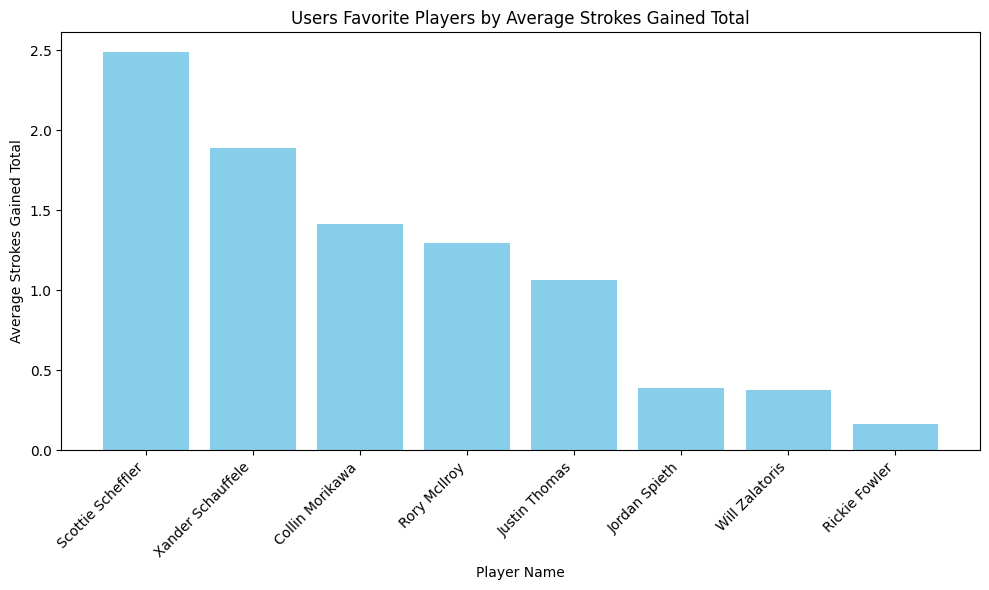

In [76]:
# query the favorites of sam and get their sg total
df = pd.read_sql_query("""
    WITH sg_season_avg AS (
        SELECT player_id, AVG(avg) AS avg
        FROM sg_total
        GROUP BY player_id
    )                       
    SELECT players.name, sg_season_avg.avg, favorites.rating
    FROM favorites
    INNER JOIN players ON favorites.player_id = players.id
    INNER JOIN users ON favorites.user_id = users.id
    INNER JOIN sg_season_avg ON favorites.player_id = sg_season_avg.player_id
    WHERE users.username = 'sam'
    AND favorites.rating <= 4
    ORDER BY sg_season_avg.avg DESC
""", conn)

# create a bar chart of those players
plt.figure(figsize=(10, 6))
plt.bar(df['name'], df['avg'], color='skyblue')
plt.xlabel('Player Name')
plt.ylabel('Average Strokes Gained Total')
plt.title('Users Favorite Players by Average Strokes Gained Total')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Second Visualization

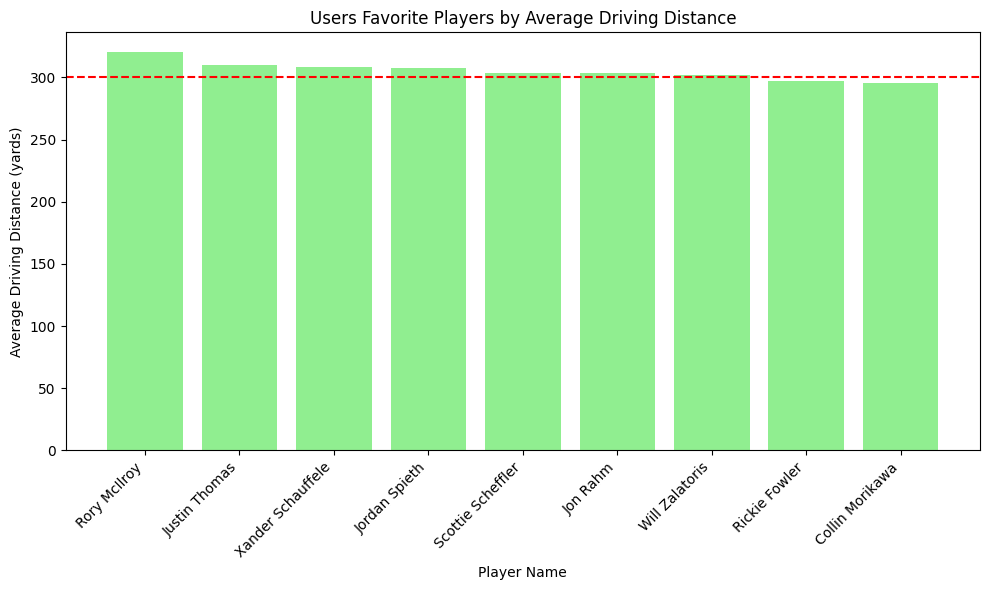

In [77]:
# get the users favorite players and their driving distance
df = pd.read_sql_query("""
    WITH driving_distance_avg AS (
        SELECT player_id, AVG(avg) AS avg
        FROM driving_distance
        GROUP BY player_id
    )
    SELECT players.name, driving_distance_avg.avg, favorites.rating
    FROM favorites
    INNER JOIN players ON favorites.player_id = players.id
    INNER JOIN users ON favorites.user_id = users.id
    INNER JOIN driving_distance_avg ON favorites.player_id = driving_distance_avg.player_id
    WHERE users.username = 'sam'
    AND favorites.rating <= 4
    ORDER BY driving_distance_avg.avg DESC
""", conn)

# create a bar chart of those players
plt.figure(figsize=(10, 6))
plt.bar(df['name'], df['avg'], color='lightgreen')
plt.xlabel('Player Name')
plt.ylabel('Average Driving Distance (yards)')
plt.title('Users Favorite Players by Average Driving Distance')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=300, color='red', linestyle='--', label='300 yards')
plt.tight_layout()
plt.show()

#### Close Connection
```python

In [78]:
conn.close()